In [1]:
import pandas as pd
import numpy as np
import os
import string
from fuzzywuzzy import fuzz, process
import sklearn
import matplotlib.pyplot as plt

from spellchecker import SpellChecker

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

/Users/kchua/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Reason Analysis

In [4]:
data = pd.read_csv('./clean_data/clean_central_data.csv')
print(data.shape)
data.head()

(10326, 79)


,Unnamed: 0,dist,district_edit,date_called_in,date_called_in_edit,date_of_spill,date_of_spill_edit,spill_number,rrc_job_number,operator_rp,...,affected_area_7_clean,spill_on_water_edit_kc,spill_on_water_edit_clean,lease_facility_name_clean,basis_kc,basis_clean,swr_20_clean,swr_98exempt_clean,cleanup_criteria_clean,cleanup_criteria_swr_91_clean
0,0,04,4,2013-01-13,2013-01-13,2013-01-13,2013-01-13,04-1238,2013-381,Headington Oil Company,...,0,no,no,"john g. kenedy ""e""",Other Rpt,other rpt,yes,no,NaN,no
1,1,06,6,2013-01-06,2013-01-06,2013-01-05,2013-01-05,1291,2013-06-195,"Quantum Resources Management, LLC",...,0,no,no,"eaton, g. w. estate",NaN,NaN,NaN,NaN,NaN,NaN
2,2,7C,7C,2013-01-22,2013-01-22,2013-01-22,2013-01-22,1829,324,EOG Resources,...,0,no,no,linthicum 'a',NaN,NaN,yes,no,NaN,yes
3,3,7C,7C,2013-01-14,2013-01-14,2013-01-13,2013-01-13,1830,191,Pioneer Natural Res. USA Inc.,...,0,no,no,"huckaby ""26""",NaN,NaN,yes,no,NaN,yes
4,4,7C,7C,2013-01-14,2013-01-14,2013-01-05,2013-01-05,1832,192,"Molopo Energy Texas, LLC",...,0,no,no,parker gh,NaN,NaN,yes,no,NaN,yes


In [10]:
data = data[[col for col in data.columns.tolist() if '_clean' in col]]
print(data.shape)
data.head()

(10326, 19)


,type_operation_clean,source_clean,probable_cause_edit_clean,comments_clean,affected_area_clean,affected_area_1_clean,affected_area_2_clean,affected_area_3_clean,affected_area_4_clean,affected_area_5_clean,affected_area_6_clean,affected_area_7_clean,spill_on_water_edit_clean,lease_facility_name_clean,basis_clean,swr_20_clean,swr_98exempt_clean,cleanup_criteria_clean,cleanup_criteria_swr_91_clean
0,production,gathering line,corrosion,leak in gathering line ds,1,1,0,0,0,0,0,0,no,"john g. kenedy ""e""",other rpt,yes,no,NaN,no
1,injection/disposal,tank battery,unknown,NaN,1,1,0,0,0,0,0,0,no,"eaton, g. w. estate",NaN,NaN,NaN,NaN,NaN
2,production,tank battery,mechanical failure,dump valve misfired,"1= on land, non-sensitive area",1,0,0,0,0,0,0,no,linthicum 'a',NaN,yes,no,NaN,yes
3,production,tank battery,mechanical failure,"water leg plugged up water went in oil tank, r...","1= on land, non-sensitive area",1,0,0,0,0,0,0,no,"huckaby ""26""",NaN,yes,no,NaN,yes
4,production,tank battery,mechanical failure,heater treater was not started ran prod tank over,"1= on land, non-sensitive area",1,0,0,0,0,0,0,no,parker gh,NaN,yes,no,NaN,yes


## Source

In [16]:
data['source_clean'].value_counts().head(50)

source_clean
tank battery               4721
flowline                   2595
well                       1092
other                       398
pipeline                    286
pump                        271
gathering line              269
tank                         65
heater treater               59
pit                          59
vehicle                      41
separator                    27
unknown                      26
plant                        21
wellhead                     21
transfer line                15
storage tank                 14
gun barrel                   11
tanks                         9
flow line                     9
frac tank                     8
injection line                8
truck                         8
load line                     8
flare                         6
tanker truck                  6
stuffing box                  4
water tank                    4
vacuum truck                  4
lact unit                     4
valve                      

/Users/kchua/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


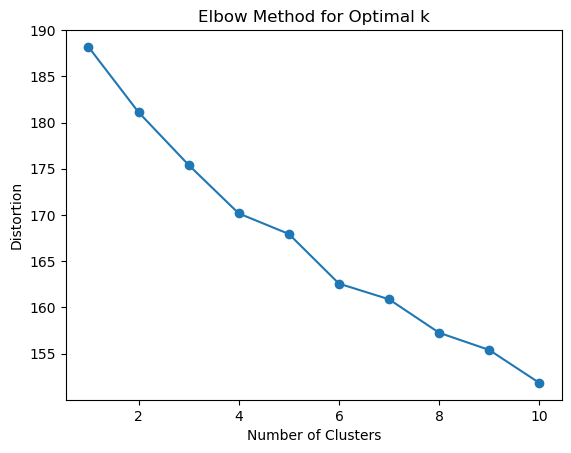

In [21]:
# Example data
data['source_clean'] = data['source_clean'].astype(str)
word_list = data['source_clean'].unique()

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(word_list)

# Experiment with a range of clusters
max_clusters = 10
distortions = []

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [22]:
optimal_clusters = 9  # Adjust based on the Elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X)

word_list_clusters = list(zip(word_list, kmeans.labels_))

for cluster_id in range(optimal_clusters):
    cluster_words = [word for word, label in word_list_clusters if label == cluster_id]
    print(f"Cluster {cluster_id + 1}: {cluster_words}")
    print()
    print()

Cluster 1: ['well', 'well head', 'well #6', 'flowline riser from well', 'well stuffing box', 'well backside', 'well cellar']


Cluster 2: ['frac tanks', 'sump frac tank', 'frac tank', 'flowback op - frac tanks']


Cluster 3: ['gathering line', 'load line', 'discharge line', 'flow line', 'transfer line', 'galvanized line', '1" circ line', 'separator line', 'pipe/flow line ?', 'vent line', 'gathering line leak', 'line from heater treater', 'sw line', 'production line', 'injection line', 'line', 'suction line', 'gatering line', 'trunk line', 'low pressure line', '8" lead line', '6" gravity line', 'ruptured 4" line', 'water transfer line', 'tubing line', 'condensate sales line', 'supply line', 'gravity line', 'total fluid line']


Cluster 4: ['pipeline', 'pipeline leak', 'pipeline riser', 'pipeline header']


Cluster 5: ['pump', 'hose', 'jet pump hose', 'charge pump', 'oil pump', 'circulating pump', 'lact pump', 'diaphram pump hose', 'swd pump', 'hose suction pump', 'transfer pump', 'pump 

In [24]:
manual_source_groups = ['well', 'tank', 'line', 'pipeline', 'truck', 'pump', 'valve', 
                       'plant']

def label_group(x, groups):
    for group in manual_source_groups:
        if group in x: 
            return group
    return 'other'

data['source_clean_labels'] = data['source_clean'].apply(lambda x: label_group(x, manual_source_groups))
data['source_clean_labels'].value_counts()

source_clean_labels
tank     4857
line     3238
well     1121
other     772
pump      286
plant      22
truck      15
valve      15
Name: count, dtype: int64

## Type Operation

In [25]:
data['type_operation_clean'].value_counts().head(50)

type_operation_clean
production                       7333
injection/disposal               2122
commercial disposal               205
transportation                    196
other                             106
drilling                           79
injection                          39
processing                         35
tank farm                          35
transport                          35
disposal                           18
pipeline                           10
gathering                           9
swd                                 5
processing facility                 3
fracking                            3
storage                             2
gathering line                      2
tank battery                        2
commingle                           2
injection/ disposal                 2
brine facility                      2
saltwater station                   2
completions                         2
gas plant                           2
plant                        

/Users/kchua/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


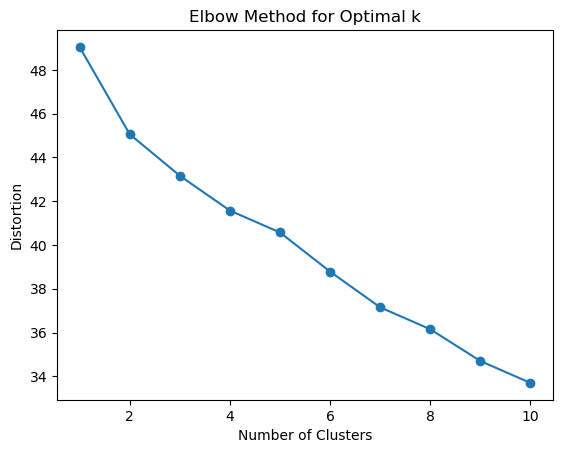

In [26]:
# Example data
data['type_operation_clean'] = data['type_operation_clean'].astype(str)
word_list = data['type_operation_clean'].unique()

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(word_list)

# Experiment with a range of clusters
max_clusters = 10
distortions = []

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()

In [27]:
optimal_clusters = 9  # Adjust based on the Elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X)

word_list_clusters = list(zip(word_list, kmeans.labels_))

for cluster_id in range(optimal_clusters):
    cluster_words = [word for word, label in word_list_clusters if label == cluster_id]
    print(f"Cluster {cluster_id + 1}: {cluster_words}")
    print()
    print()

Cluster 1: ['gathering', 'gathering line']


Cluster 2: ['injection/disposal', 'injection', 'injection/ disposal', 'injection well', 'disposal/injection']


Cluster 3: ['production', 'nan', 'other', 'tank farm', 'swd', 'completion', 'pipeline', 'fracking', 'trucking', 'plugging', 'completions', 'transport', 'orphan', 'midstream', 'sw line', 'pits', 'pigging', 'abandoned', 'rectifier', 'water hauler', 'commingle', 'waste collection and skimming', 'inj/disp', 'tank battery', 'dcp', 'cpf', 'trasportation', 'productiom', 'transfer', 'saltwater station', 'transporation']


Cluster 4: ['processing', 'processing facility', 'brine facility']


Cluster 5: ['storage']


Cluster 6: ['plant', 'gas plant']


Cluster 7: ['drilling']


Cluster 8: ['commercial disposal', 'disposal', 'disposal facility', "disposal (p&a'd well)"]


Cluster 9: ['transportation', 'transportation/disposal']




In [28]:
manual_source_groups = ['gathering', 'injection/disposal', 'transportation', 'plant']

def label_group(x, groups):
    for group in manual_source_groups:
        if group in x: 
            return group
    return 'other'

data['type_operation_clean_labels'] = data['type_operation_clean'].apply(lambda x: label_group(x, manual_source_groups))
data['type_operation_clean_labels'].value_counts()

type_operation_clean_labels
other                 7992
injection/disposal    2122
transportation         197
gathering               11
plant                    4
Name: count, dtype: int64